In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import numpy as np
import IPython.display as ipd
import scipy.signal as signal
import scipy.interpolate as pol

import timeit

In [2]:
# Create an audio recording 
def sinusoid (freq = 440, dur = 1.0, srate = 44100.0, amp = 1.0, phase = 0.0):
    t = np.linspace(0, dur, int(dur*srate))
    data = amp*np.sin(2*np.pi*freq*t + phase)
    return data

srate = 44100
a_note = 440.0
c_note = 523.0
d_note = 587.0
e_note = 659.0

a_data = sinusoid(a_note, 0.5)
c_data = sinusoid(c_note, 0.5)
d_data = sinusoid(d_note, 0.5)
e_data = sinusoid(e_note, 0.5)
sound1 = np.hstack([c_data, d_data, e_data])

ipd.Audio(sound1, rate = 44100)

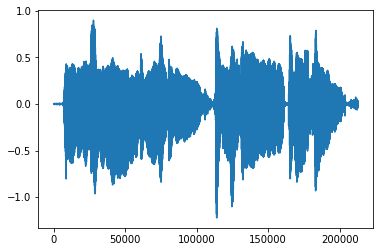

In [3]:
#Load an audio recording
srate2, audio_signal = wav.read("amazing_grace_female.wav")
sound2 = audio_signal.astype(np.float32)/32767.0
sound2 = 0.9/max(sound2)*sound2

plt.plot(sound2)

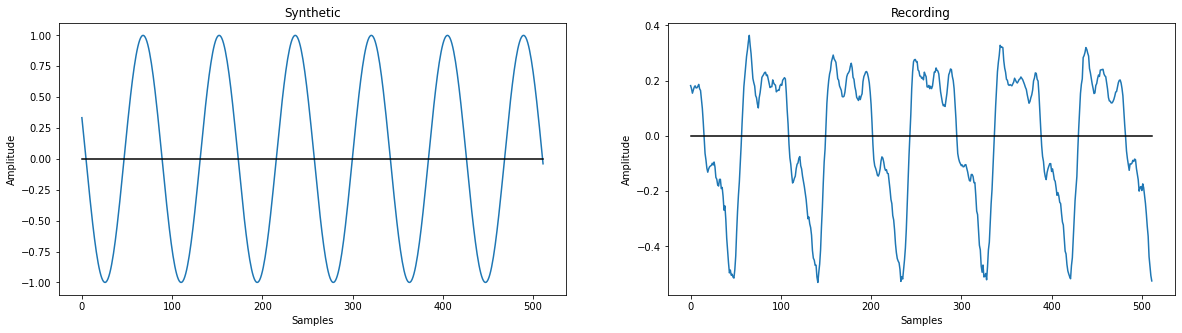

In [4]:
# Short time audio processing
hop_size = 256
window_size = 512

o = 40*hop_size
frame_test = a_data[o : o+window_size]
frame1 = sound1[o : o+window_size]
frame2 = sound2[o : o+window_size]

plt.figure(figsize = (20,5))
plt.subplot(121)
plt.title("Synthetic")
plt.plot(frame1)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.plot(np.zeros(len(frame1)), color = 'black')

plt.subplot(122)
plt.title("Recording")
plt.plot(frame2)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.plot(np.zeros(len(frame1)), color = 'black')

In [5]:
#Visualizing Short time processing
#def plot_short_time(signal, hopSize, winSize, start_frame, dur_frame):
#     s = start_frame
#     long_chunk = signal[start_frame*hopSize : (start_frame + dur_frame)*hopSize]
    
#     plt.figure(figsize=(20,5))
#     plt.plot(long_chunk)
    
#     for m in np.arange(0,4): 
#         start = m * hopSize 
#         end = m * hopSize + winSize 
#         frame = long_chunk[start:end]
#         plt.plot(np.arange(start, end), frame - (m+1)* 2.0)
#         plt.xticks(np.arange(0, len(long_chunk), step=hopSize))
#         plt.text(0, -4, 'Frame1', fontsize=16, color='orange')
#         plt.text(hopSize, -6, 'Frame2', fontsize=16, color='green')
#         plt.text(2*hopSize, -8, 'Frame3', fontsize=16, color='red')


#     plt.yticks([])
#     plt.grid(True)

# plot a chunk of the synthetic input as well as the audio recording 
#plot_short_time(sound1, 256, 512, 40, 5)
#plot_short_time(sound2, 256, 512, 40, 5)

# change the hop size and window size 
#plot_short_time(sound1, 128, 256, 40, 5)
        

In [10]:
# Comparing different pitch extraction Algorithms like Average Magnitude Difference Function(AMDF), Zero Crossing(ZCR)
# and FFT

# AMDF Function implementation
%time
def pitch_amdf(frame, srate):
    N = len(frame)
    amdf = np.zeros(N)
    val = []
    for m in np.arange(0,N):
        for n in np.arange(0,N-1-m):
            amdf[m] += np.abs(frame[n] - frame[n+m])
             
    #peak = signal.find_peaks(amdf)
    
    for samp in np.arange(1,N-1):
        if((amdf[samp-1]>amdf[samp]) & (amdf[samp]<amdf[samp+1])):
            val.append(samp)
        
    lag = np.mean(np.diff(val))
    pitch_estimate = srate/lag
    return (pitch_estimate)

# AMDF function tested 
(p9) = pitch_amdf(frame2, srate2)
#plt.plot(amdf9)
print(p9)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
335.78680203045684


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


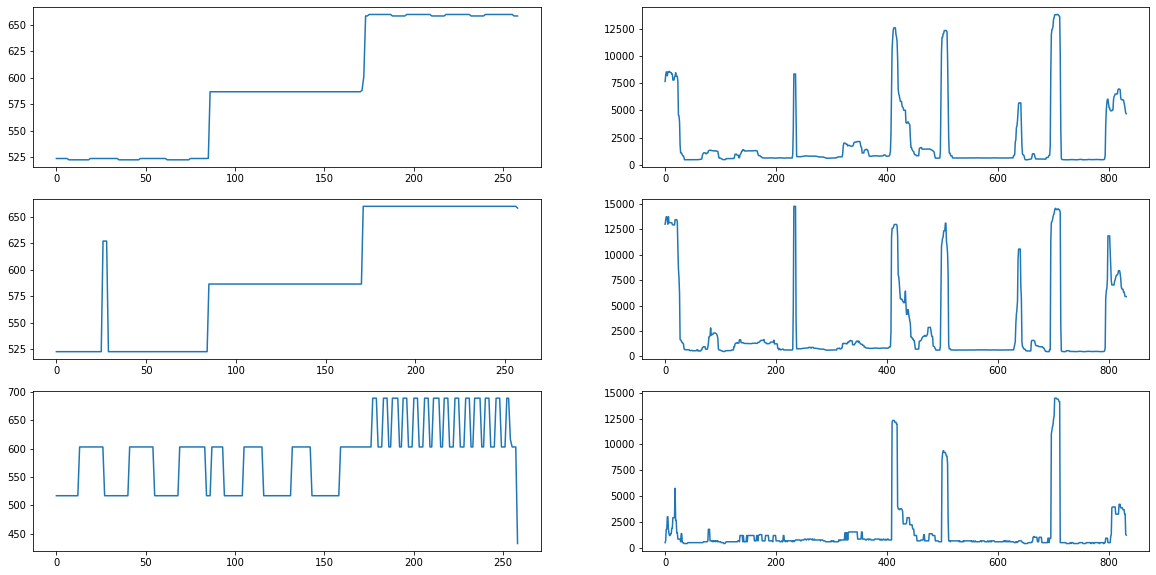

In [11]:
# We can measure the times of other algorithms 

%time
def pitch_zcrs(frame, srate):
    indices = np.nonzero((frame[1:] > 0) & (frame[:-1] < 0))[0]
    pitch_estimate = srate / np.mean(np.diff(indices))
    return pitch_estimate

%time
def pitch_fft(frame, srate):
    mag = np.fft.fft(frame)
    mag = mag[0:int(len(mag)/2)]
    pitch_estimate = np.argmax(mag)*srate/len(frame)
    return pitch_estimate


def pitch_track(signal, hopSize, winSize, extractor): 
    offsets = np.arange(0, len(signal), hopSize)
    pitch_track = np.zeros(len(offsets))
    amp_track = np.zeros(len(offsets))
    
    for (m,o) in enumerate(offsets): 
        frame = signal[o:o+winSize] 
        pitch_track[m] = extractor(frame, srate)
        amp_track[m] = np.sqrt(np.mean(np.square(frame)))  

      #  if (pitch_track[m] > 1500): 
       #     pitch_track[m] = 0 
        
    return (amp_track, pitch_track)

    
    
# compute the pitch tracks 
(at1, pt1) = pitch_track(sound1, 256, 512, pitch_zcrs)
(at2, pt2) = pitch_track(sound2, 256, 512, pitch_zcrs)
(at3, pt3) = pitch_track(sound1, 256, 512, pitch_amdf)
(at4, pt4) = pitch_track(sound2, 256, 512, pitch_amdf)
(at5, pt5) = pitch_track(sound1, 256, 512, pitch_fft)
(at6, pt6) = pitch_track(sound2, 256, 512, pitch_fft)


# applying median filtering to smooth the pitch tracks 
pt1s = signal.medfilt(pt1, kernel_size=7)
pt2s = signal.medfilt(pt2, kernel_size=7)
pt3s = signal.medfilt(pt3, kernel_size=7)
pt4s = signal.medfilt(pt4, kernel_size=7)
pt5s = signal.medfilt(pt5, kernel_size=7)
pt6s = signal.medfilt(pt6, kernel_size=7)


plt.figure(figsize=(20,10)) 
plt.subplot(321)
plt.plot(pt1s)
plt.subplot(322)
plt.plot(pt2s)
plt.subplot(323)
plt.plot(pt3s)
plt.subplot(324)
plt.plot(pt4s)
plt.subplot(325)
plt.plot(pt5s)
plt.subplot(326)
plt.plot(pt6s)

In [12]:
def sonify(amp_track, pitch_track, srate, hop_size):

    times = np.arange(0.0, float(hop_size * len(pitch_track)) / srate,
                      float(hop_size) / srate)

    # sample locations in time (seconds)                                                      
    sample_times = np.linspace(0, np.max(times), int(np.max(times)*srate-1))

    # create linear interpolators for frequencies and amplitudes                              
    # so that we have a frequency and amplitude value for 
    # every sample 
    freq_interpolator = pol.interp1d(times,pitch_track)
    amp_interpolator = pol.interp1d(times,amp_track)

    # use the interpolators to calculate per sample frequency and                             
    # ampitude values                                                                         
    sample_freqs = freq_interpolator(sample_times)
    sample_amps  = amp_interpolator(sample_times)

    # create audio signal                                                                     
    audio = np.zeros(len(sample_times));
    T = 1.0 / srate
    phase = 0.0
    
    # update phase according to the sample frequencies 
    for i in range(1, len(audio)):
        audio[i] = sample_amps[i] * np.sin(phase)
        phase = phase + (2*np.pi*T*sample_freqs[i])

    return audio



In [13]:
# Listening to the pitch contours

# ZCR
pt2_audio = sonify(at2, pt2, srate, hop_size)
ipd.Audio(pt2_audio,rate=srate)




In [14]:
#AMDF
pt4_audio = sonify(at4, pt4, srate, hop_size)
ipd.Audio(pt4_audio,rate=srate)


In [25]:
#FFT
pt6_audio = sonify(at6, pt6, srate, hop_size)
ipd.Audio(pt6_audio,rate=srate)


In [19]:
# Mean Squared Error

e01 = pt4-pt2

e1 = (1/len(pt4))*np.sum((pt2-pt4)*(pt2-pt4))
e2 = (1/len(pt4))*np.sum((pt2-pt6)*(pt2-pt6))

print(e1)
print(e2)

1723040.1286191468
3536189.0689535695


In [20]:
# My perception was that ZCR sounds the best and the AMDF error is less